## Proof of Concept

### 1. Data Pre-Processing

In [1]:
import os
import pandas as pd
import numpy
from matplotlib import pyplot as plt
plt.style.use('seaborn')

os.chdir("C:\\Users\\Admin\\Wearable")

In [2]:
path = 'EMG_data_for_gestures-master\\EMG_data_for_gestures-master\\'
subject_ids = [(lambda x: '0' if x<10 else '')(x)+str(x) for x in range(1,36)]
file_dirs = []

for id_ in subject_ids:
    files = os.listdir(path+id_)
    for file in files:
        file_dirs.append(os.path.join(path,id_,file))

df_list = []
for path in file_dirs:
    df_i = pd.read_csv(path, delimiter = '\t')
    df_i['subject_id'] = int(path[58:60])
    df_list.append(df_i)
    
def rms(timeseries, win_size, skip_samples):
    other_data = timeseries[['time','class','subject_id']]
    timeseries = timeseries.drop(['time','class','subject_id'],axis=1)
    timeseries = timeseries - timeseries.mean()
    median = timeseries.rolling(window=win_size).median()
    timeseries = timeseries.sub(median).apply(lambda x: x**2).rolling(window=win_size).sum().apply(lambda x: (x/win_size)**0.5)
    timeseries = pd.concat([timeseries,other_data], axis = 1)
    
    return timeseries.iloc[skip_samples-1:][::skip_samples]

print("Data Loaded")


Data Loaded


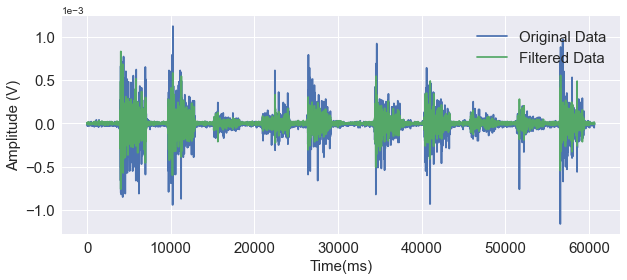

In [3]:
import numpy as np
from scipy.fft import fft, ifft
from scipy.signal import butter, lfilter

channels = ['channel'+str(i) for i in range(1,9)]

def bandpass_filter(signal, fs, f_low, f_high, order=5):
    
    # Compute the Fourier Transform
    signal_fft = fft(signal)
    freqs = np.fft.fftfreq(len(signal), 1 / fs)
    # Create a bandpass filter
    b, a = butter(order, [f_low, f_high], fs=fs, btype='band')
    # Apply the filter in the frequency domain
    filtered_fft = signal_fft * ((freqs >= f_low) & (freqs <= f_high))
    # Convert the filtered signal back to the time domain
    filtered_signal = np.real(ifft(filtered_fft))
    # Apply the filter to remove edge effects
    filtered_signal = lfilter(b, a, filtered_signal)
    
    return filtered_signal

# Define the frequency band you want to preserve 
lowcut =20
highcut = 450
fs = 1000
# Apply the bandpass filter
df_list_filt = []
for data in df_list:
    df_temp = pd.DataFrame()
    df_temp = pd.concat([df_temp,data[['time','class','subject_id']]], axis = 1)
    for channel in channels:
        filtered_data = bandpass_filter(data[channel].to_numpy(),fs, lowcut, highcut)
        df_temp[channel]  = filtered_data
    df_list_filt.append(df_temp)
    
# Plot the original and filtered data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(df_list[1]['time'], df_list[1]['channel1'], label='Original Data')
plt.plot(df_list_filt[1]['time'],df_list_filt[1]['channel1'] , label='Filtered Data')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Time(ms)',fontsize=15)
plt.ylabel('Amplitude (V)',fontsize=15)
plt.legend(fontsize=15)
plt.show()


In [4]:
# Extracting rms
df_list_rms = []
for i in range(len(df_list_filt)):
    df_list_rms.append(rms(df_list_filt[i],100,20))
    
df = pd.concat(df_list_rms, ignore_index=True)
df = df.dropna()
df

,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,time,class,subject_id
9,0.000006,0.000010,0.000013,0.000014,0.000006,0.000003,0.000004,0.000003,221,0.0,1
10,0.000006,0.000009,0.000013,0.000012,0.000006,0.000003,0.000004,0.000003,243,0.0,1
11,0.000007,0.000009,0.000011,0.000011,0.000007,0.000003,0.000005,0.000003,266,0.0,1
12,0.000006,0.000007,0.000009,0.000007,0.000006,0.000003,0.000005,0.000002,290,0.0,1
13,0.000006,0.000007,0.000008,0.000008,0.000006,0.000003,0.000003,0.000002,312,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
206771,0.000006,0.000005,0.000009,0.000020,0.000010,0.000008,0.000005,0.000002,50556,0.0,35
206772,0.000005,0.000005,0.000009,0.000017,0.000011,0.000006,0.000004,0.000002,50577,0.0,35
206773,0.000005,0.000005,0.000008,0.000014,0.000012,0.000006,0.000004,0.000002,50598,0.0,35
206774,0.000004,0.000006,0.000008,0.000013,0.000012,0.000004,0.000003,0.000002,50618,0.0,35


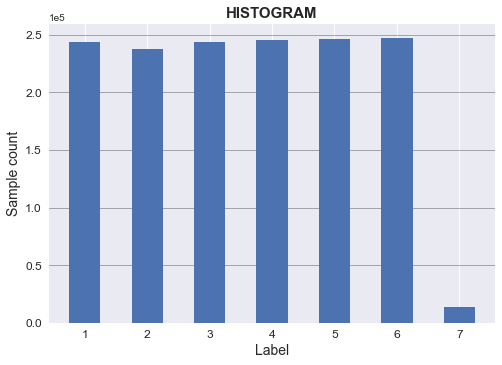

In [5]:
concated_data = pd.concat([df_ for df_ in df_list],axis=0)
from matplotlib import pyplot as plt

# Plotting histogram
feats = concated_data[~concated_data['class'].isin([0])][channels].to_numpy() #dropping unlabeled data
labels = concated_data[~concated_data['class'].isin([0])]['class'].to_numpy()


plt.bar(np.arange(1,8),np.histogram(labels.astype(int),bins=np.arange(1,9))[0],width = 0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid(color = 'black',axis='y', alpha =0.3)
plt.xlabel('Label',fontsize=14)
plt.ylabel('Sample count',fontsize=14)
plt.title('HISTOGRAM', weight='bold',fontsize=15)
plt.show()

### 2. Exploratory Data  Analysis

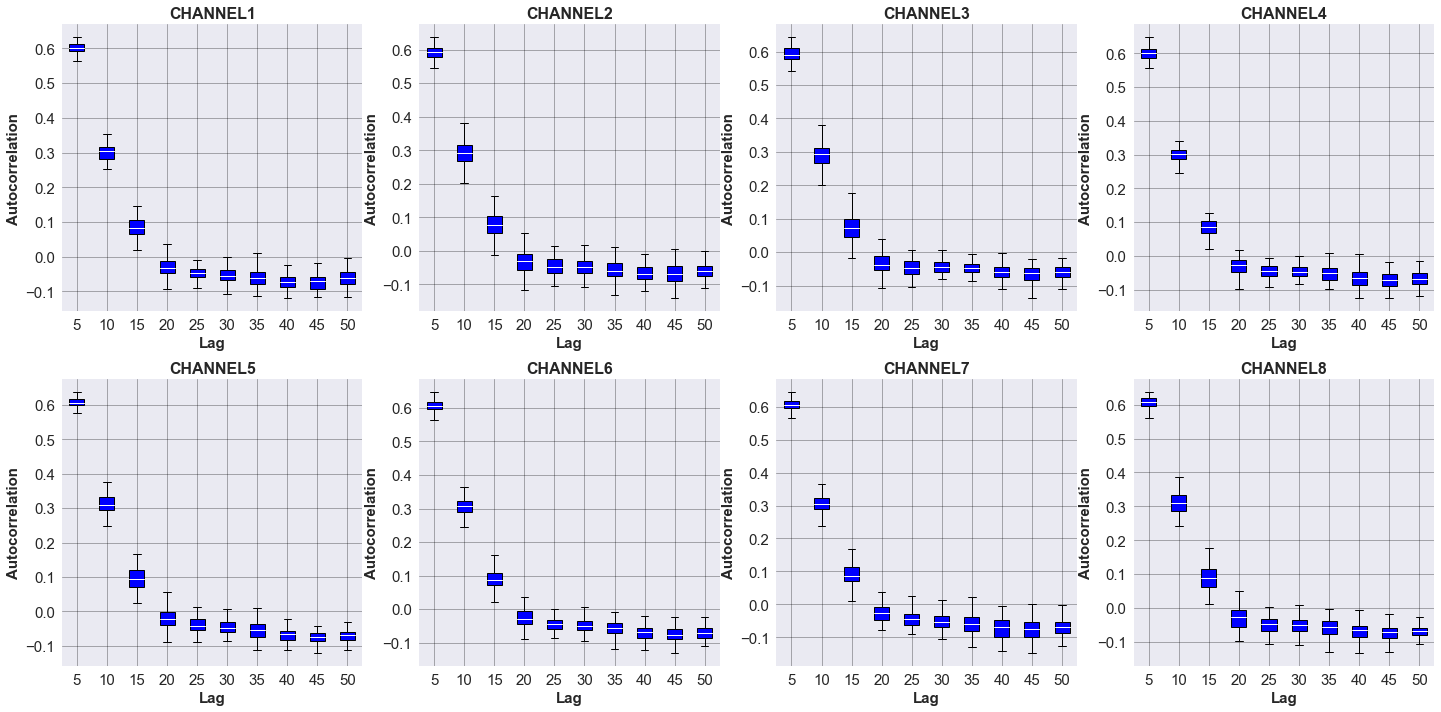

In [6]:
from statsmodels.graphics.tsaplots import plot_acf,acf
import numpy as np

fig, ax = plt.subplots(2,4,figsize=(20,10))
plt.style.use('seaborn')
channels = ['channel'+str(i) for i in range(1,9)]
for i in range(2):
    for j in range(4):
        acf_vals = np.array([])
        for k in range(70):
            data = df_list[k][channels[(lambda x: j if  i < 1 else j + 4)(j)]]
            acf_vals = np.append(acf_vals,acf(data, nlags=50)) # Extracting autocorrelations
        acf_vals = np.reshape(acf_vals,(70,51))
        sk = acf_vals.T[5:][::5].T
        boxplot = ax[i][j].boxplot(sk,showfliers=False,medianprops={'color': 'white'}, patch_artist = True)
        box_color = 'blue'
        for box in boxplot['boxes']:
            box.set(facecolor=box_color)
           
        ax[i][j].grid(color='black', alpha=0.3)
        ax[i][j].set_xticks(np.arange(1, sk.shape[1]+1))
        ax[i][j].set_xticklabels(np.arange(5, acf_vals.shape[1],5),fontsize=15)
        ax[i][j].tick_params(axis='y', labelsize=15)
        ax[i][j].set_ylabel('Autocorrelation', weight = 'bold',fontsize=15)
        ax[i][j].set_xlabel('Lag', weight = 'bold',fontsize=15)
        ax[i][j].set_title(str.upper(channels[(lambda x: j if  i < 1 else j + 4)(j)]), weight = 'bold',fontsize=16)
# plt.suptitle('AUTOCORRELATION VS LAG',weight = 'bold',fontsize=18)
plt.tight_layout()

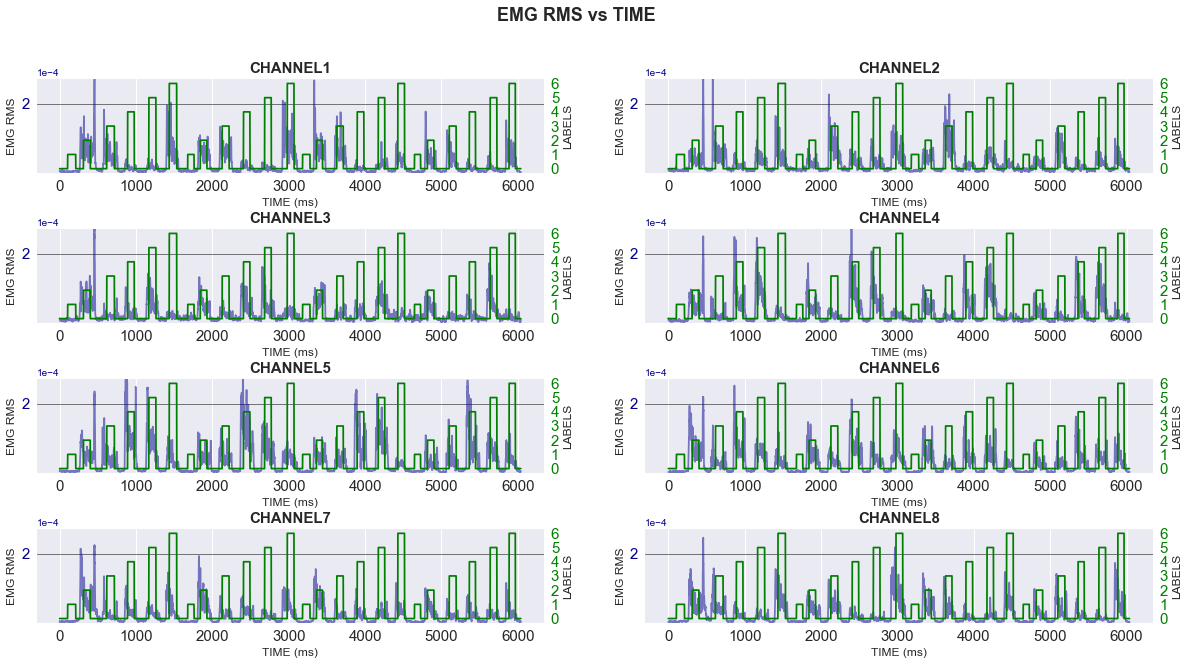

In [7]:
import matplotlib.pyplot as plt 
import numpy as np

#Plotting RMS vs Time for channel 1
fig, ax1 = plt.subplots(4,2,figsize=(20,10))
df1 = df[df['subject_id']==1]
id_ = 1
y_max = df1['channel1'].max()
for i in range(4):
    for j in range(2):
        channel_name = 'channel'+ str(id_)
        id_+=1
        ax2 = ax1[i][j].twinx()
        ax1[i][j].plot(np.linspace(0,len(df1),len(df1)),df1[channel_name],color = "darkblue",alpha = 0.5)
        ax1[i][j].tick_params(axis = 'y', labelsize=15, labelcolor = 'darkblue')
        ax1[i][j].tick_params(axis = 'x', labelsize=15)
        ax1[i][j].set_ylabel('EMG RMS',fontsize=12)
        ax2.set_ylabel('LABELS',fontsize=12)
        ax1[i][j].set_xlabel('TIME (ms)',fontsize=12)
        ax1[i][j].set_yticks([0.0002,.0004,0.0006,0.0008,0.0010])
        ax2.tick_params(labelsize=15,labelcolor='green')
        ax1[i][j].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax2.plot(np.linspace(0,len(df1),len(df1)),df1['class'],color = "green")
        ax2.set_yticks([0,1,2,3,4,5,6])
        ax2.grid(False)
        ax1[i][j].set_ylim([0,y_max])
        ax1[i][j].grid(axis = 'y',color='black', alpha = 0.5)
        ax1[i][j].set_title(str.upper(channel_name), weight = 'bold',fontsize = 15)
fig.subplots_adjust(hspace=0.6)
plt.suptitle('EMG RMS vs TIME',weight = 'bold',fontsize=18)
plt.show()

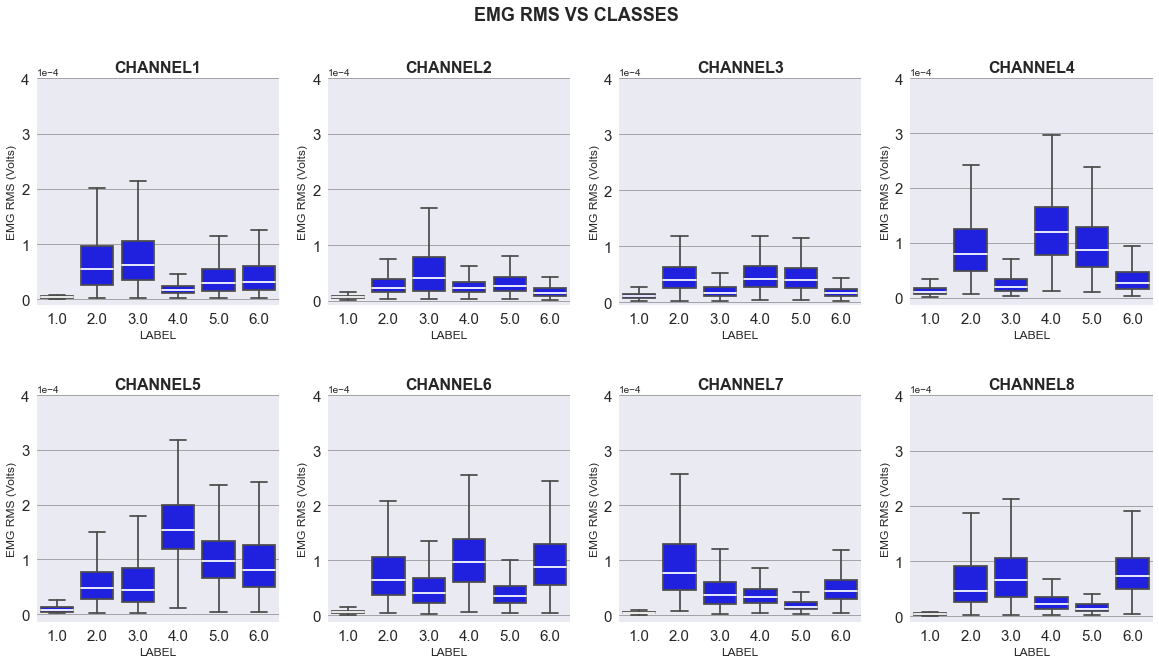

In [8]:
import seaborn as sns

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
plt.style.use('seaborn')

id_ = 1
for i in range(2):
    for j in range(4):
        channel_name = 'channel'+ str(id_)
        id_ += 1
        sns.boxplot(x='class', y=channel_name, data= df[~df['class'].isin([0,7])], ax=ax[i][j], color='blue', showfliers=False, medianprops={'color': 'white'})
        ax[i][j].set_ylabel('EMG RMS (Volts)',fontsize=12)
        ax[i][j].tick_params(labelsize=15)
        ax[i][j].set_yticks(np.linspace(0,0.0004,5))
        ax[i][j].grid(axis = 'y', color = 'black', alpha = 0.3)
        ax[i][j].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax[i][j].set_xlabel('LABEL',fontsize=12)
        ax[i][j].set_title(str.upper(channel_name), weight='bold',fontsize=16)
fig.subplots_adjust(hspace=0.4)
plt.suptitle('EMG RMS VS CLASSES',weight = 'bold',fontsize=18)
plt.show()

### 3. Combined Data Pipeline

In [9]:
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter("ignore", category= FutureWarning)
from sklearn.decomposition import PCA



class pipeline():
    def __init__(self, df_list,win_size,rows_to_skip):
        self.df_list = df_list
        self.win_size = win_size
        self.rows_to_skip = rows_to_skip
        self.pca = PCA(n_components=8)
        self.channel_names = ['channel'+str(i) for i in range(1,9)]
        self.compute_rms()
        self.feats, self.labels = self.standardize()
        
        self.pca.fit(self.feats)
        self.feats = self.pca_transform()
        
    
    def rms(self,timeseries):
        other_data = timeseries[['time','class','subject_id']]
        timeseries = timeseries.drop(['time','class','subject_id'],axis=1)
        timeseries = timeseries - timeseries.mean()
        mean = timeseries.rolling(window=self.win_size).mean()
        timeseries = timeseries.sub(mean).apply(lambda x: x**2).rolling(window=self.win_size).sum().apply(
            lambda x: (x/self.win_size)**0.5)
        timeseries = pd.concat([timeseries,other_data], axis = 1)
        return timeseries.iloc[::self.rows_to_skip]
    
    def compute_rms(self):
        df_list_rms = []
        for i in range(len(self.df_list)):
            df_list_rms.append(self.rms(self.df_list[i]))
        self.df = pd.concat(df_list_rms, ignore_index=True)
        self.df = self.df.dropna()
        self.df = self.df[self.df['class'].isin([1,2,3,4,5,6])]
        
        
    def pca_transform(self,feats = None):
        if feats is None:
            feats = self.feats
        return self.pca.transform(feats)
        
        
    def standardize(self, df = None):
        if df is None:
            df = self.df
            self.scaling = StandardScaler()
            self.scaling.fit(df[self.channel_names].to_numpy())
        features = df[self.channel_names].to_numpy()
        labels = df['class'].to_numpy().astype(int)
        scaled_feats = self.scaling.transform(features)
        return scaled_feats, labels
    
    def process(self, df):
        rms_df = self.rms(df).dropna()
        rms_df = rms_df[rms_df['class'].isin([1,2,3,4,5,6])]
        feats, labels = self.standardize(rms_df)
        return self.pca_transform(feats), labels
         

### 4.Principal Component Analysis

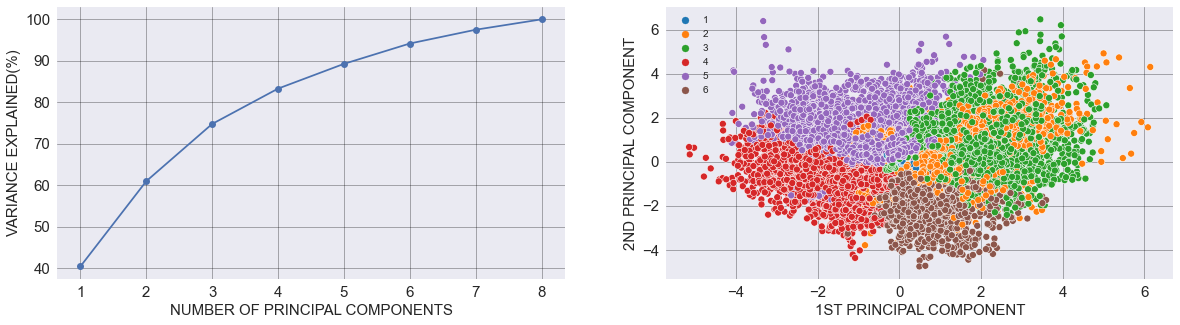

In [10]:

# Transforming data with win_size = 100 and overlap = 20
pip = pipeline([df_list_filt[i] for i in range(35)],100,20)

# print the transformed data
explained_variance = []
for i in range(1,feats.shape[1]+1):
    explained_variance.append(sum(pip.pca.explained_variance_ratio_[:i])*100)

fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(np.linspace(1,pip.feats.shape[1], pip.feats.shape[1]),explained_variance,marker = 'o')
ax[0].set_ylabel(str.upper('Variance explained(%)'),fontsize=15)
ax[0].tick_params(labelsize=15)
ax[0].grid(True, color = 'black', alpha = 0.3)
ax[0].set_xlabel(str.upper('Number of principal components'),fontsize=15)
# ax[0].set_title('VARIANCE EXPLAINED (%) vs NUMBER OF PRINCIPAL COMPONENTS', weight = 'bold', fontsize=18)
sns.scatterplot(pip.feats[:,1],pip.feats[:,2],marker = 'o', hue= pip.labels, ax = ax[1],palette = "tab10")
ax[1].set_ylabel(str.upper('2nd Principal Component'),fontsize=15)
ax[1].tick_params(labelsize=15)
ax[1].grid(True, color = 'black', alpha = 0.3)
ax[1].set_xlabel(str.upper('1st Principal Component'),fontsize=15)
# ax[1].set_title(str.upper('Orthographic projection in PC space'), weight = 'bold', fontsize=18)

plt.show()

### 5. Model Development and Evaluation 
#### 5.1 Support Vector Machine
Experiment 1. Window size = 100 ms

In [11]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

# Splitting data into test, train and validation sets
train_val_ids, test_ids = train_test_split(np.arange(0,70).astype(int), test_size=0.3, random_state=42)
train_ids, val_ids = train_test_split(train_val_ids, test_size=0.3, random_state=42)

pip = pipeline([df_list_filt[i] for i in train_ids],100,20)

svm_acc_win_100 = []
C_array = [0.1,1,10,100] 
for C in tqdm(C_array):
    # Fitting the model
    svm_classifier = svm.SVC(kernel='rbf',C= C)
    svm_classifier.fit(pip.feats,pip.labels)
    acc = np.array([])
    for i in val_ids:
        f,l = pip.process(df_list_filt[i])
        pred = svm_classifier.predict(f)
        acc = np.append(acc, accuracy_score(l,pred))
    svm_acc_win_100 = np.append(svm_acc_win_100,acc)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:08<00:00, 47.00s/it]


In [12]:
svm_acc_win_100 = svm_acc_win_100.reshape(4,-1)
print('Optimum C =',C_array[np.argmax(np.mean(svm_acc_win_100,axis=1))])

Optimum C = 1


In [13]:
pip = pipeline([df_list_filt[i] for i in train_val_ids],100,20)
svm_ = svm.SVC(kernel='rbf',C= 1)
svm_.fit(pip.feats,pip.labels)
svm_test_acc_win_100 = []
for i in tqdm(test_ids):
    f,l = pip.process(df_list_filt[i])
    pred = svm_.predict(f)
    svm_test_acc_win_100 = np.append(svm_test_acc_win_100, accuracy_score(l,pred))
print("Accuracy on the test set:",round(np.mean(svm_test_acc_win_100)*100,2),"+/-",round(np.std(svm_test_acc_win_100)*100,2))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:58<00:00,  2.76s/it]

Accuracy on the test set: 85.93 +/- 8.59


Experiment 2 : Window size = 200ms 

In [14]:
from sklearn import svm
pip = pipeline([df_list_filt[i] for i in train_ids],200,20)

svm_acc_win_200 = []
C_array = [0.1,1,10,100] 

for C in tqdm(C_array):
    svm_classifier = svm.SVC(kernel='rbf',C= C)
    svm_classifier.fit(pip.feats,pip.labels)
    acc = np.array([])
    for i in val_ids:
        f,l = pip.process(df_list_filt[i])
        pred = svm_classifier.predict(f)
        acc = np.append(acc, accuracy_score(l,pred))
    svm_acc_win_200 = np.append(svm_acc_win_200,acc)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:29<00:00, 37.40s/it]


In [15]:
svm_acc_win_200 = svm_acc_win_200.reshape(4,-1)
print('Optimum C =',C_array[np.argmax(np.mean(svm_acc_win_200,axis=1))])

Optimum C = 0.1


In [16]:
from sklearn import svm
pip = pipeline([df_list_filt[i] for i in train_val_ids],200,20)
svm_ = svm.SVC(kernel='rbf',C= 10)
svm_.fit(pip.feats,pip.labels)
svm_test_acc_win_200 = []
for i in tqdm(test_ids):
    f,l = pip.process(df_list_filt[i])
    pred = svm_.predict(f)
    svm_test_acc_win_200 = np.append(svm_test_acc_win_200, accuracy_score(l,pred))

print("Accuracy on the test set:",round(np.mean(svm_test_acc_win_200)*100,2),"+/-",round(np.std(svm_test_acc_win_200)*100,2))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:36<00:00,  1.74s/it]

Accuracy on the test set: 88.87 +/- 8.19


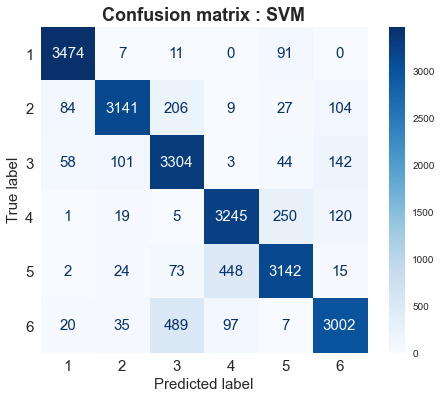

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
f, l = pip.process(pd.concat([df_list_filt[i] for i in test_ids]))
pred = svm_.predict(f)
disp = ConfusionMatrixDisplay(confusion_matrix(l, pred),display_labels = set(l))
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax = ax,cmap = 'Blues')
for text in ax.texts:
    text.set_fontsize(15)

# Adjust grid visibility
ax.grid(visible=False)
ax.tick_params(labelsize=15)
ax.set_xlabel('Predicted label', fontsize=15)
ax.set_ylabel('True label', fontsize=15)

# Adjust transparency of the plot
ax.patch.set_alpha(0.6)
plt.title('Confusion matrix : SVM',  weight = 'bold', fontsize=18)
plt.show()

In [18]:
from sklearn.metrics import classification_report

report = classification_report(l, pred, digits = 4)
print(report)

              precision    recall  f1-score   support

           1     0.9547    0.9696    0.9621      3583
           2     0.9441    0.8796    0.9107      3571
           3     0.8082    0.9047    0.8537      3652
           4     0.8535    0.8915    0.8721      3640
           5     0.8823    0.8483    0.8650      3704
           6     0.8874    0.8225    0.8537      3650

    accuracy                         0.8857     21800
   macro avg     0.8884    0.8860    0.8862     21800
weighted avg     0.8880    0.8857    0.8858     21800



####  5.2. Random Forest Classifier
Experiment 1: Window size = 100ms 

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

pip = pipeline([df_list_filt[i] for i in train_ids],100,20)

rfc_acc_win_100 = []
Trees_array = [50, 100,200]
rfc_array = []
for t in tqdm(Trees_array):
    rfc = RandomForestClassifier(n_estimators=t, random_state=42,oob_score=True)
    rfc_array.append(rfc)
    rfc.fit(pip.feats,pip.labels)
    acc = np.array([])
    for i in val_ids:
        f,l = pip.process(df_list_filt[i])
        pred = rfc.predict(f)
        acc = np.append(acc, accuracy_score(l,pred))
    rfc_acc_win_100 = np.append(rfc_acc_win_100,acc)
rfc_acc_win_100 = rfc_acc_win_100.reshape(3,-1)
tuned_rfc = rfc_array[np.argmax(np.median(rfc_acc_win_100,axis=1))]
print('Optimum Trees =',Trees_array[np.argmax(np.median(rfc_acc_win_100,axis=1))])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:43<00:00, 14.54s/it]

Optimum Trees = 200


In [20]:
pip = pipeline([df_list_filt[i] for i in train_val_ids],100,20)
tuned_rfc.fit(pip.feats,pip.labels)
rfc_test_acc_win_100 = []
for i in tqdm(test_ids):
    f,l = pip.process(df_list_filt[i])
    pred = tuned_rfc.predict(f)
    rfc_test_acc_win_100 = np.append(rfc_test_acc_win_100, accuracy_score(l,pred))

print("Accuracy on the test set:",round(np.mean(rfc_test_acc_win_100)*100,1),"+/-",round(np.std(rfc_test_acc_win_100)*100,1))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.30it/s]

Accuracy on the test set: 84.4 +/- 9.5


Experiment 2: Window size = 200ms

In [21]:
from sklearn import svm
pip = pipeline([df_list_filt[i] for i in train_val_ids],200,20)
tuned_rfc.fit(pip.feats,pip.labels)
rfc_test_acc_win_200 = []
for i in tqdm(test_ids):
    f,l = pip.process(df_list_filt[i])
    pred = tuned_rfc.predict(f)
    rfc_test_acc_win_200 = np.append(rfc_test_acc_win_200, accuracy_score(l,pred))

print("Accuracy on the test set:",round(np.mean(rfc_test_acc_win_200)*100,1),"+/-",round(np.std(rfc_test_acc_win_200)*100,1))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.62it/s]

Accuracy on the test set: 86.8 +/- 9.5


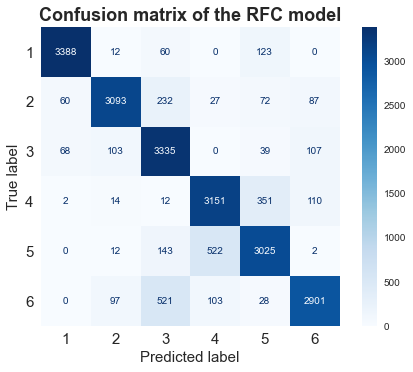

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
f, l = pip.process(pd.concat([df_list_filt[i] for i in test_ids]))
pred = tuned_rfc.predict(f)
disp = ConfusionMatrixDisplay(confusion_matrix(l, pred),display_labels = set(l))
fig, ax = plt.subplots()
disp.plot(ax=ax, cmap='Blues')

# Adjust grid visibility
ax.grid(visible=False)
ax.tick_params(labelsize=15)
ax.set_xlabel('Predicted label', fontsize=15)
ax.set_ylabel('True label', fontsize=15)

# Adjust transparency of the plot
ax.patch.set_alpha(0.6)
plt.title('Confusion matrix of the RFC model',  weight = 'bold', fontsize=18)
plt.show()

In [23]:
report = classification_report(l, pred, digits = 4)
print(report)

              precision    recall  f1-score   support

           1     0.9630    0.9456    0.9542      3583
           2     0.9285    0.8661    0.8963      3571
           3     0.7750    0.9132    0.8385      3652
           4     0.8286    0.8657    0.8467      3640
           5     0.8315    0.8167    0.8240      3704
           6     0.9046    0.7948    0.8461      3650

    accuracy                         0.8667     21800
   macro avg     0.8719    0.8670    0.8676     21800
weighted avg     0.8713    0.8667    0.8672     21800



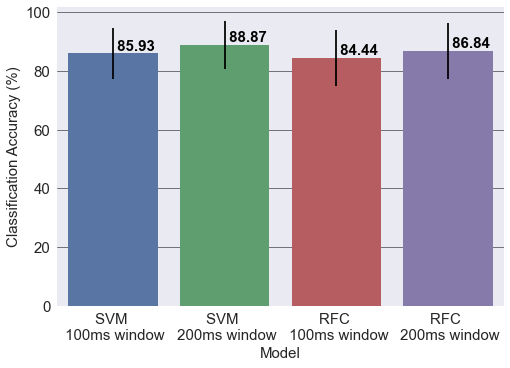

In [24]:
import seaborn as sns

# Create sample data
categories = ['SVM \n 100ms window', 'SVM \n 200ms window', 'RFC \n 100ms window', 'RFC \n 200ms window']
values = [np.mean(svm_test_acc_win_100),np.mean(svm_test_acc_win_200),np.mean(rfc_test_acc_win_100),np.mean(rfc_test_acc_win_200)]
errors = [np.std(svm_test_acc_win_100),np.std(svm_test_acc_win_200),np.std(rfc_test_acc_win_100),np.std(rfc_test_acc_win_200)]
values = np.array(values)*100
errors = np.array(errors)*100

# Plot barplot with error bars
sns.barplot(x=categories, y=values, ci='sd', yerr=errors)

for i, v in enumerate(values):
    plt.annotate('\n '+str(round(v,2)), (i, v), ha='left', va='bottom', weight= 'bold',fontsize=15, color='black')

# Set labels and title
plt.xlabel('Model', fontsize=15)
plt.ylabel('Classification Accuracy (%)', fontsize=15)
plt.title(str.upper(''),weight = 'bold', fontsize=18)
plt.tick_params(labelsize=15)

plt.grid(True,color='black',axis='y',alpha=0.5)
# Show the plot
plt.show()
